# Анализ сервиса аренды самокатов
Были получены данные от сервиса аренды самокатов GoFast.
Датасеты содерждат информацию об определённом количестве пользователей из нескольких городов, а также об их поездках. 
Задача — проанализировать данные и проверитьгипотезы, которые могут помочь бизнесу. 
Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться:

**без подписки**

- абонентская плата отсутствует;
- стоимость одной минуты поездки — 8 рублей;
- стоимость старта (начала поездки) — 50 рублей;

**с подпиской Ultra**

- абонентская плата — 199 рублей в месяц;
- стоимость одной минуты поездки — 6 рублей;
- стоимость старта — бесплатно.

На основе этих данных требуется проверить следующие **гипотезы**:
1. Тратят ли пользователи с подпиской больше времени на поездки? 
2. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? 
3. Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки? 

**Добавляем нужные в дальнейшем библиотеки.**

In [1]:
import pandas as pd
from scipy import stats as st
import numpy as np
import matplotlib.pyplot as plt

#### Шаг 1. Загрузка данных

In [2]:
users = pd.read_csv('/datasets/users_go.csv')
rides = pd.read_csv('/datasets/rides_go.csv')
subs = pd.read_csv('/datasets/subscriptions_go.csv')

In [3]:
display(users.head(10)) #изучаем информацию о датасетах
display(rides.head(10))
display(subs.head(5))

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra
5,6,Регина,25,Краснодар,ultra
6,7,Игорь,23,Омск,ultra
7,8,Юрий,23,Краснодар,ultra
8,9,Ян,21,Пятигорск,ultra
9,10,Валерий,18,Екатеринбург,ultra


,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28
5,1,2770.890808,16.650138,2021-10-09
6,1,3039.020292,14.927879,2021-10-19
7,1,2842.118050,23.117468,2021-11-06
8,1,3412.690668,15.238072,2021-11-14
9,1,748.690645,15.041884,2021-11-22


,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [4]:
users.info() #изучаем информацию о датасетах
rides.info()
subs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Col

**Вывод. В 1 и 2 датасетах приведены данные о более чем 1500 пользователях и их 18 000 поездках. В первом 5 колонок, 1565 cтрок, тип данных int64 (2) и object (3); во втором 4 столбца, 18068 строк, float64(2), int64(1), object(1); 
user_id является общей;
в 3 датасете представлены 4 столбца, int64(3), object(1), типы подписки: без подписки и с подпиской Ultra и соответствующие расценки по минутам и за старт самоката.**

#### Шаг 2. Предобработка данных

**Проведём предобработку данных, оценим количество пропусков и дубликатов.**

In [5]:
users.isna().sum().sort_values(ascending=False) #находим столбцы с пропусками в 1 дф

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

In [6]:
rides.isna().sum().sort_values(ascending=False) #находим столбцы с пропусками во 2 дф
                                                #третий дф не трогаем, так как там лишь типы подписки и нет большого массива данных
                                                

user_id     0
distance    0
duration    0
date        0
dtype: int64

**Пропусков не обнаружено, теперь поработаем с дубликатами.**

In [7]:
len(users[users.duplicated()])

31

In [8]:
len(rides[rides.duplicated()]) #во втором датасете явных дубликатов не обнаружено

0

In [9]:
print(users.loc[users['user_id'].duplicated()]) #вывел все явные дубликаты, на всякий случай ниже удостоверимся в повторе

      user_id        name  age            city subscription_type
1534      293       Агата   26       Краснодар             ultra
1535       16      Амалия   27       Краснодар             ultra
1536      909  Константин   20    Екатеринбург              free
1537      403      Полина   19            Сочи             ultra
1538      908      Рустам   30          Тюмень              free
1539       43    Стефания   22            Омск             ultra
1540      127       Павел   25       Пятигорск             ultra
1541      659       Злата   27  Ростов-на-Дону             ultra
1542      204      Руслан   30       Пятигорск             ultra
1543      153      Герман   23          Москва             ultra
1544     1245      Регина   27       Пятигорск              free
1545      807   Александр   28    Екатеринбург              free
1546      924       Мария   23       Пятигорск              free
1547      635      Герман   21          Москва             ultra
1548      136     Марсель

In [10]:
print(users.loc[users['user_id']== 293])#действительно, некоторые айди повторяются
print(users.loc[users['user_id']== 16])

      user_id   name  age       city subscription_type
292       293  Агата   26  Краснодар             ultra
1534      293  Агата   26  Краснодар             ultra
      user_id    name  age       city subscription_type
15         16  Амалия   27  Краснодар             ultra
1535       16  Амалия   27  Краснодар             ultra


**Уберём повторяющиеся значения.**

In [11]:
users = users.drop_duplicates().reset_index(drop=True)

**Взглянем на столбец 'name'.**

In [12]:
users['name'].value_counts()

Анна         22
Мария        22
Дмитрий      17
Александр    17
Никита       16
             ..
Алина         3
Семен         2
Радмир        1
Тихон         1
Милана        1
Name: name, Length: 194, dtype: int64

In [13]:
len(users[users['name'].duplicated()])

1340

In [14]:
name_list = users.loc[users['name'].notna(), 'name'].unique()
name_list.sort()
j = 0
for elem in name_list:
    print(f'{elem:<35}', end='|')
    j += 1
    if j == 3:
        print()
        j = 0

Агата                              |Аделина                            |Адель                              |
Айдар                              |Александр                          |Александра                         |
Алексей                            |Алина                              |Алиса                              |
Алия                               |Алла                               |Альберт                            |
Альбина                            |Алёна                              |Амалия                             |
Амина                              |Амир                               |Анастасия                          |
Анатолий                           |Ангелина                           |Андрей                             |
Анжелика                           |Анна                               |Антон                              |
Антонина                           |Ариана                             |Арина                              |
Арсен              

**Аномалий в данном столбце не обнаружил.**

**Изменим тип данных у столбца 'date' датасета rides на to_datetime.
Создадим новый столбец с номером месяца на основе столбца date**

In [15]:
rides['date'] = pd.to_datetime(rides['date'], format='%Y-%m-%dT%H:%M:%S') #меняем тип данных из object в date_time
rides['date_month'] = pd.DatetimeIndex(rides['date']).month 

In [16]:
rides['date'].sort_values().unique()

array(['2021-01-01T00:00:00.000000000', '2021-01-02T00:00:00.000000000',
       '2021-01-03T00:00:00.000000000', '2021-01-04T00:00:00.000000000',
       '2021-01-05T00:00:00.000000000', '2021-01-06T00:00:00.000000000',
       '2021-01-07T00:00:00.000000000', '2021-01-08T00:00:00.000000000',
       '2021-01-09T00:00:00.000000000', '2021-01-10T00:00:00.000000000',
       '2021-01-11T00:00:00.000000000', '2021-01-12T00:00:00.000000000',
       '2021-01-13T00:00:00.000000000', '2021-01-14T00:00:00.000000000',
       '2021-01-15T00:00:00.000000000', '2021-01-16T00:00:00.000000000',
       '2021-01-17T00:00:00.000000000', '2021-01-18T00:00:00.000000000',
       '2021-01-19T00:00:00.000000000', '2021-01-20T00:00:00.000000000',
       '2021-01-21T00:00:00.000000000', '2021-01-22T00:00:00.000000000',
       '2021-01-23T00:00:00.000000000', '2021-01-24T00:00:00.000000000',
       '2021-01-25T00:00:00.000000000', '2021-01-26T00:00:00.000000000',
       '2021-01-27T00:00:00.000000000', '2021-01-28

**В данном разделе были обработаны дубликаты в users['user_id] , изменён тип данных у rides['date'], добавлен новый столбец rides['date_month'] с указанием номера месяца, когда была совершена поездка. Определил, что данные получены за 2021 год.**

#### Шаг 3. Исследовательский анализ данных

**Опишем и визуализируем общую информацию о пользователях и поездках.**

**3.1. Частота встречаемости городов.**

Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: city, dtype: int64

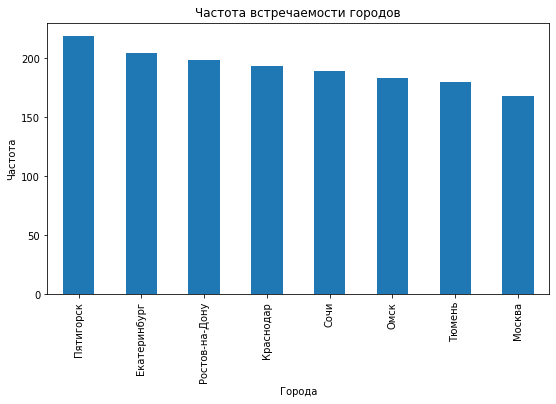

In [17]:
users['city'].value_counts().plot(
    title='Частота встречаемости городов', xlabel='Города', 
    ylabel='Частота', legend=False, kind='bar', figsize=(9,5))
users['city'].value_counts()

In [18]:
users['city'].value_counts()

Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: city, dtype: int64

In [19]:
users['city'].unique()

array(['Тюмень', 'Омск', 'Москва', 'Ростов-на-Дону', 'Краснодар',
       'Пятигорск', 'Екатеринбург', 'Сочи'], dtype=object)

**Больше всего поездок, в исследуемой выборке, совершили пользователи из Пятигорска, меньше всего из Москвы, всего встречается 8 городов.**

**3.2. Соотношение пользователей с подпиской и без.**

<AxesSubplot:ylabel='subscription_type'>

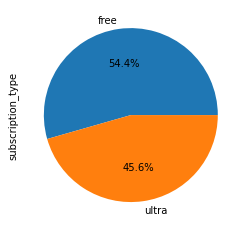

In [20]:
users['subscription_type'].value_counts().plot(kind='pie', autopct='%1.1f%%')

In [21]:
len(users['subscription_type'])

1534

In [22]:
len(users.loc[users['subscription_type']=='ultra'])

699

**Пользователи с подпиской составляют 46% против 54% пользователей без подписки.**

**3.3. Возраст пользователей.**

Text(0.5, 1.0, 'Возраст пользователей')

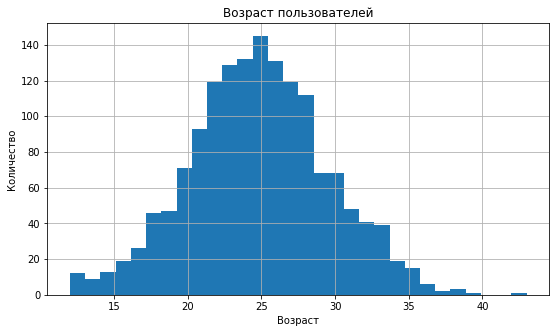

In [23]:
users['age'].plot(kind = 'hist', grid=True, figsize = (9,5), bins = 30)
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.title('Возраст пользователей')

In [24]:
users['age'].describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

**Представлена выборка от 12 до 43 лет, среднее и медиана практически равны. Большинство пользователей в возрасте от 20 до 30.**

**3.4. расстояние, которое пользователь преодолел за одну поездку.**

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

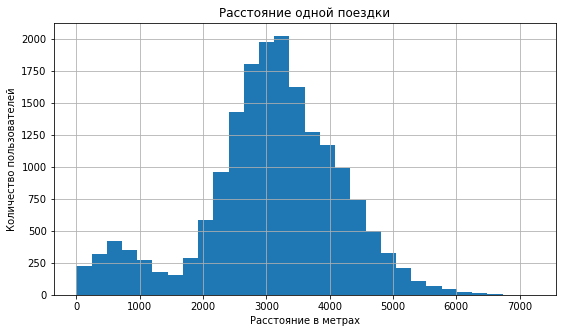

In [25]:
rides['distance'].plot(kind = 'hist', grid=True, figsize = (9,5), bins = 30)
plt.title('Расстояние одной поездки')
plt.xlabel('Расстояние в метрах')
plt.ylabel('Количество пользователей')
rides['distance'].describe()

**Видим два пика, на отрезке от 0 до 1000 метров и на 3000 метров, большинство поездок совершается именно на это расстояние, определённая зависимость есть.**

**3.5. продолжительность поездок.**

In [26]:
rides['duration'].describe()

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

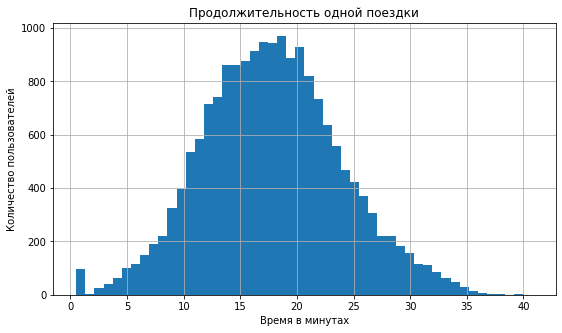

In [27]:
rides['duration'].plot(kind = 'hist', grid=True, figsize = (9,5), bins = 50)
plt.title('Продолжительность одной поездки')
plt.xlabel('Время в минутах')
plt.ylabel('Количество пользователей');

In [28]:
rides = rides.loc[rides['duration']>=1]

**Пик на отметке в 20 минут, большинство поездок длились от 10 до 25 минут. Убрал аномальные значения, которые меньше минуты.**

**Вывод: в данном разделе были определены города, в которых совершались поездки, проанализированы расстояние, продолжительность поездок, возраст пользователей, а также соотношение людей с подпиской и без.**

#### Шаг 4. Объединение данных

**4.1. Объедините данные о пользователях, поездках и подписках в один датафрейм.**

In [29]:
merged_df = rides.merge(users, how = 'left', on = 'user_id' )
merged_df = merged_df.merge(subs, how = 'left', on='subscription_type')
display(merged_df)

,user_id,distance,duration,date,date_month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.919140,25.599769,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.592153,15.816871,2021-01-18,1,Кира,22,Тюмень,ultra,6,0,199
2,1,754.159807,6.232113,2021-04-20,4,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.783254,18.511000,2021-08-11,8,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.687306,26.265803,2021-08-28,8,Кира,22,Тюмень,ultra,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
17968,1534,3781.098080,19.822962,2021-11-04,11,Альберт,25,Краснодар,free,8,50,0
17969,1534,2840.423057,21.409799,2021-11-16,11,Альберт,25,Краснодар,free,8,50,0
17970,1534,3826.185507,18.435051,2021-11-18,11,Альберт,25,Краснодар,free,8,50,0
17971,1534,2902.308661,16.674362,2021-11-27,11,Альберт,25,Краснодар,free,8,50,0


**Размер таблицы по строкам соответствует логически ожидаемому.**

**4.2. Создадим ещё два датафрейма из датафрейма, созданного на этапе 4.1.**

In [30]:
no_sub = merged_df.loc[merged_df['subscription_type']=='free'] #пользователи без подписки
sub = merged_df.loc[merged_df['subscription_type']=='ultra']   #пользователи с подпиской

In [31]:
sub 

,user_id,distance,duration,date,date_month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.919140,25.599769,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.592153,15.816871,2021-01-18,1,Кира,22,Тюмень,ultra,6,0,199
2,1,754.159807,6.232113,2021-04-20,4,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.783254,18.511000,2021-08-11,8,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.687306,26.265803,2021-08-28,8,Кира,22,Тюмень,ultra,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
6495,699,3973.046497,24.671163,2021-08-29,8,Оксана,22,Москва,ultra,6,0,199
6496,699,3288.702563,15.892886,2021-09-12,9,Оксана,22,Москва,ultra,6,0,199
6497,699,3076.159348,14.389525,2021-09-26,9,Оксана,22,Москва,ultra,6,0,199
6498,699,4707.845501,15.839579,2021-10-17,10,Оксана,22,Москва,ultra,6,0,199


In [32]:
no_sub

,user_id,distance,duration,date,date_month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
6500,700,2515.690719,14.944286,2021-01-02,1,Айдар,22,Омск,free,8,50,0
6501,700,846.932642,16.234663,2021-02-01,2,Айдар,22,Омск,free,8,50,0
6502,700,4004.434142,20.016628,2021-02-04,2,Айдар,22,Омск,free,8,50,0
6503,700,1205.911290,9.782872,2021-02-10,2,Айдар,22,Омск,free,8,50,0
6504,700,3047.379435,17.427673,2021-02-14,2,Айдар,22,Омск,free,8,50,0
...,...,...,...,...,...,...,...,...,...,...,...,...
17968,1534,3781.098080,19.822962,2021-11-04,11,Альберт,25,Краснодар,free,8,50,0
17969,1534,2840.423057,21.409799,2021-11-16,11,Альберт,25,Краснодар,free,8,50,0
17970,1534,3826.185507,18.435051,2021-11-18,11,Альберт,25,Краснодар,free,8,50,0
17971,1534,2902.308661,16.674362,2021-11-27,11,Альберт,25,Краснодар,free,8,50,0


**Пользователи без подписки совершили в 1.78 раза больше поездок, чем пользователи с подпиской.**

**4.3. Визуализируем информацию о расстоянии и времени поездок для пользователей обеих категорий.**

Text(0, 0.5, 'Количество пользователей')

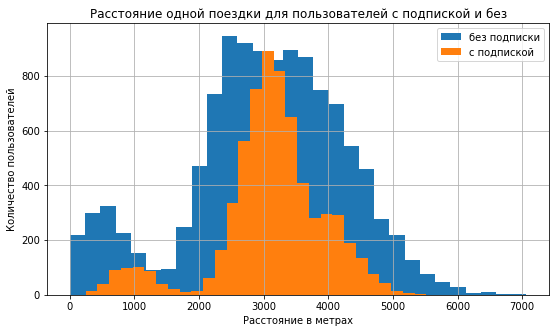

In [33]:
x = no_sub['distance'].plot(kind = 'hist', grid=True,figsize = (9,5),bins = 30,label='без подписки',legend=True)
x = sub['distance'].plot(kind = 'hist',grid=True,figsize = (9,5),bins = 30,label='с подпиской',legend=True)
plt.title('Расстояние одной поездки для пользователей с подпиской и без')
plt.xlabel('Расстояние в метрах')
plt.ylabel('Количество пользователей')

Text(0, 0.5, 'Количество пользователей')

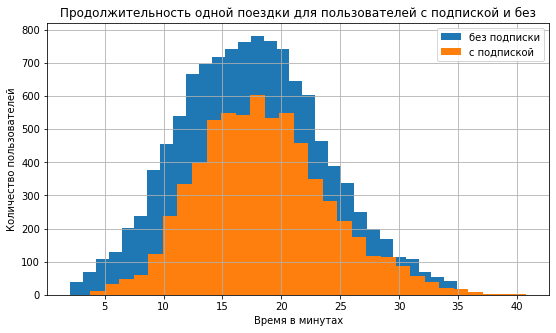

In [34]:
x = no_sub['duration'].plot(kind = 'hist',grid=True,figsize = (9,5),bins = 30,label='без подписки',legend=True)
x = sub['duration'].plot(kind = 'hist',grid=True,figsize = (9,5),bins = 30,label='с подпиской',legend=True)
plt.title('Продолжительность одной поездки для пользователей с подпиской и без')
plt.xlabel('Время в минутах')
plt.ylabel('Количество пользователей')

**На графиках заметны различия, скорее всего это вызвано тем, что пользователи без подписки совершили больше поездок, в остальном оба графика имеют схожее нормальное распределение.**

#### Шаг 5. Подсчёт выручки

**5.1. Создадим датафрейм с агрегированными данными о поездках на основе датафрейма с объединёнными данными из шага 4: найдём суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц.**

In [35]:
merged_df['duration'] = np.ceil(merged_df['duration']) #округляем
merged_df['duration'] = merged_df['duration'].astype('int') #приводим к типу int

In [36]:
agged_df = merged_df.pivot_table(index=['user_id','date_month'],values=['duration','distance'], aggfunc=['count','sum'])

In [37]:
agged_df.columns = ['count_distance', 'count_duration', 'sum_distance','sum_duration']
agged_df = agged_df.drop(columns=['count_duration'])
agged_df = agged_df.reset_index()

In [38]:
agged_df

,user_id,date_month,count_distance,sum_distance,sum_duration
0,1,1,2,7027.511294,42
1,1,4,1,754.159807,7
2,1,8,2,6723.470560,46
3,1,10,2,5809.911100,32
4,1,11,3,7003.499363,56
...,...,...,...,...,...
11295,1534,6,2,3409.468534,26
11296,1534,8,2,7622.453034,48
11297,1534,9,1,4928.173852,23
11298,1534,11,4,13350.015305,78


**5.2. В этот же датафрейм добавим столбец с помесячной выручкой, которую принёс каждый пользователь.**

In [39]:
agged_df = agged_df.merge(users, how='left', on='user_id')
agged_df = agged_df.merge(subs, how = 'left', on='subscription_type')
agged_df

,user_id,date_month,count_distance,sum_distance,sum_duration,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,1,2,7027.511294,42,Кира,22,Тюмень,ultra,6,0,199
1,1,4,1,754.159807,7,Кира,22,Тюмень,ultra,6,0,199
2,1,8,2,6723.470560,46,Кира,22,Тюмень,ultra,6,0,199
3,1,10,2,5809.911100,32,Кира,22,Тюмень,ultra,6,0,199
4,1,11,3,7003.499363,56,Кира,22,Тюмень,ultra,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
11295,1534,6,2,3409.468534,26,Альберт,25,Краснодар,free,8,50,0
11296,1534,8,2,7622.453034,48,Альберт,25,Краснодар,free,8,50,0
11297,1534,9,1,4928.173852,23,Альберт,25,Краснодар,free,8,50,0
11298,1534,11,4,13350.015305,78,Альберт,25,Краснодар,free,8,50,0


In [40]:
def revenue(row):
  revenue_sum = 0
  revenue_sum = (row['start_ride_price'] * row['count_distance'] +
              row['minute_price'] * row['sum_duration'] + row['subscription_fee'])
  return revenue_sum

In [41]:
agged_df['revenue'] = agged_df.apply(revenue, axis=1)
revenue = agged_df[['user_id', 'name', 'date_month', 'revenue']]
display(revenue)

,user_id,name,date_month,revenue
0,1,Кира,1,451
1,1,Кира,4,241
2,1,Кира,8,475
3,1,Кира,10,391
4,1,Кира,11,535
...,...,...,...,...
11295,1534,Альберт,6,308
11296,1534,Альберт,8,484
11297,1534,Альберт,9,234
11298,1534,Альберт,11,824


**Также рассчитаем общую сумму, потраченную каждым пользователем.**

In [42]:
print(agged_df.groupby('user_id')['revenue'].sum())

user_id
1       2460
2       2611
3       2827
4       2952
5       2672
        ... 
1530    3258
1531    4502
1532    2410
1533    2618
1534    2538
Name: revenue, Length: 1534, dtype: int64


**В данном разделе добавил столбец с помесячной выручкой, посчитал сколько денег принёс каждый пользователь.**

#### Шаг 6. Проверка гипотез

**6.1. Проверим гипотезу о том, что пользователи с подпиской могут быть «выгоднее» для компании, для этого рассмотрим исходные данные о продолжительности каждой сессии — отдельно для подписчиков и тех, у кого нет подписки.**

In [43]:
sub

,user_id,distance,duration,date,date_month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.919140,25.599769,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.592153,15.816871,2021-01-18,1,Кира,22,Тюмень,ultra,6,0,199
2,1,754.159807,6.232113,2021-04-20,4,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.783254,18.511000,2021-08-11,8,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.687306,26.265803,2021-08-28,8,Кира,22,Тюмень,ultra,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
6495,699,3973.046497,24.671163,2021-08-29,8,Оксана,22,Москва,ultra,6,0,199
6496,699,3288.702563,15.892886,2021-09-12,9,Оксана,22,Москва,ultra,6,0,199
6497,699,3076.159348,14.389525,2021-09-26,9,Оксана,22,Москва,ultra,6,0,199
6498,699,4707.845501,15.839579,2021-10-17,10,Оксана,22,Москва,ultra,6,0,199


In [44]:
no_sub

,user_id,distance,duration,date,date_month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
6500,700,2515.690719,14.944286,2021-01-02,1,Айдар,22,Омск,free,8,50,0
6501,700,846.932642,16.234663,2021-02-01,2,Айдар,22,Омск,free,8,50,0
6502,700,4004.434142,20.016628,2021-02-04,2,Айдар,22,Омск,free,8,50,0
6503,700,1205.911290,9.782872,2021-02-10,2,Айдар,22,Омск,free,8,50,0
6504,700,3047.379435,17.427673,2021-02-14,2,Айдар,22,Омск,free,8,50,0
...,...,...,...,...,...,...,...,...,...,...,...,...
17968,1534,3781.098080,19.822962,2021-11-04,11,Альберт,25,Краснодар,free,8,50,0
17969,1534,2840.423057,21.409799,2021-11-16,11,Альберт,25,Краснодар,free,8,50,0
17970,1534,3826.185507,18.435051,2021-11-18,11,Альберт,25,Краснодар,free,8,50,0
17971,1534,2902.308661,16.674362,2021-11-27,11,Альберт,25,Краснодар,free,8,50,0


**Так как выборки являются независимыми друг от друга, подойдет метод scipy.stats.ttest_ind.**
- H0: среднее время поездок пользователей с подпиской и пользователей без подписки равны;
- H1: пользователи с подпиской тратят больше времени.

In [45]:
alpha = 0.05

results = st.ttest_ind(sub['duration'], no_sub['duration'], alternative='greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 
print('Среднее время поездки c подпиской:', round(sub['duration'].mean(),2))
print('Среднее время поездки без подписки:', round(no_sub['duration'].mean(),2))

p-значение: 4.704468074453899e-28
Отвергаем нулевую гипотезу
Среднее время поездки c подпиской: 18.54
Среднее время поездки без подписки: 17.53


**Вывод. Пользователи с подпиской в среднем тратили больше времени, чем пользователи без подписки, следовательно они выгоднее для компании.**

**6.2.Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?**

**Так как выборка одна и проверяется гипотеза о равенстве среднего генеральной совокупности числу, использую метод scipy.stats.ttest_1samp.**
- H0: среднее расстояние поездки пользователя с подпиской равна 3130 метрам;
- H1: среднее расстояние поездки пользователя с подпиской не длиннее 3130 метров.

In [46]:
interested_value = 3130 # оптимальное кол-во метров за одну поездку

alpha = 0.05 

results = st.ttest_1samp(sub['distance'], interested_value, alternative='greater')

print('p-значение:', results.pvalue)

if results.pvalue <= alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')
print('Средняя дистанция поездки c подпиской:', round(sub['distance'].mean()))

p-значение: 0.9195368847849785
Не получилось отвергнуть нулевую гипотезу
Средняя дистанция поездки c подпиской: 3115


**Вывод. Не удалось отвергнуть нулевую гипотезу, среднее расстояние пользователя с подпиской равно 3115. Cреднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров**

**6.3. Проверьте гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.**

**Для проверки этой гипотезы, используем метод из пункта 6.1, так как выборки независимы:**
- H0: помесячная выручка от пользователей с подпиской и без равны;
- H1: помесячная выручка от пользователей с подпиской выше, чем от пользователей без подписки.

In [47]:
month_revenue_sub = agged_df[agged_df['subscription_type'] == 'ultra']
month_revenue_sub

,user_id,date_month,count_distance,sum_distance,sum_duration,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee,revenue
0,1,1,2,7027.511294,42,Кира,22,Тюмень,ultra,6,0,199,451
1,1,4,1,754.159807,7,Кира,22,Тюмень,ultra,6,0,199,241
2,1,8,2,6723.470560,46,Кира,22,Тюмень,ultra,6,0,199,475
3,1,10,2,5809.911100,32,Кира,22,Тюмень,ultra,6,0,199,391
4,1,11,3,7003.499363,56,Кира,22,Тюмень,ultra,6,0,199,535
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4528,699,6,1,4072.797406,17,Оксана,22,Москва,ultra,6,0,199,301
4529,699,8,2,7018.324143,45,Оксана,22,Москва,ultra,6,0,199,469
4530,699,9,2,6364.861911,31,Оксана,22,Москва,ultra,6,0,199,385
4531,699,10,1,4707.845501,16,Оксана,22,Москва,ultra,6,0,199,295


In [48]:
month_revenue_no_sub = agged_df[agged_df['subscription_type'] == 'free']
month_revenue_no_sub

,user_id,date_month,count_distance,sum_distance,sum_duration,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee,revenue
4533,700,1,1,2515.690719,15,Айдар,22,Омск,free,8,50,0,170
4534,700,2,5,13446.659764,89,Айдар,22,Омск,free,8,50,0,962
4535,700,3,1,3798.334905,19,Айдар,22,Омск,free,8,50,0,202
4536,700,4,1,2984.551206,16,Айдар,22,Омск,free,8,50,0,178
4537,700,6,2,5927.650988,29,Айдар,22,Омск,free,8,50,0,332
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11295,1534,6,2,3409.468534,26,Альберт,25,Краснодар,free,8,50,0,308
11296,1534,8,2,7622.453034,48,Альберт,25,Краснодар,free,8,50,0,484
11297,1534,9,1,4928.173852,23,Альберт,25,Краснодар,free,8,50,0,234
11298,1534,11,4,13350.015305,78,Альберт,25,Краснодар,free,8,50,0,824


In [49]:
alpha = 0.05 

results = st.ttest_ind(month_revenue_sub['revenue'], month_revenue_no_sub['revenue'], alternative='greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')
print('Средняя месячная выручка от пользователей с подпиской:', round(month_revenue_sub['revenue'].mean(),2))
print('Средняя месячная выручка от пользователей без подписки:', round(month_revenue_no_sub['revenue'].mean(),2))

p-значение: 2.0314113674863288e-30
Отвергаем нулевую гипотезу
Средняя месячная выручка от пользователей с подпиской: 362.79
Средняя месячная выручка от пользователей без подписки: 329.33


**Отвергаем нулевую гипотезу, среднемесячная выручка от пользователей с подпиской выше.**

**6.4.  Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?**

**Рассматриваем гипотезу о равенстве двух средних для зависимых выборок:**
- H0:u1 равно u2;
- H1:u2 < u1;
- u1 и u2 — средние до и после изменения.
 
**Cледовательно, нужно в метод scipy.stats.ttest_rel() передать два параметра: наборы данных до обновления и после него.**

#### Общий вывод.

**При исследовании и анализе сервиса удалось выяснить:**

- Приведены данные о более чем 1500 пользователях и их 18 000 поездках;
- Больше всего поездок совершили пользователи из Пятигорска, меньше всего из Москвы, всего встречается 8 городов;
- Пользователи с подпиской составляют 46% против 54% пользователей без подписки;
- Представлена выборка от 12 до 43 лет, среднее и медиана практически равны. Большинство пользователей в возрасте от 20 до 30;
- Большинство поездок совершается на отрезке от 2000 до 5000, есть пик на отрезке 0-1000;
- Большинство поездок длились от 10 до 25 минут;
- Среднее время поездки c подпиской: 18.54;
- Среднее время поездки без подписки: 17.39;
- Пользователи с подпиской в среднем тратили больше времени, чем пользователи без подписки, следовательно они выгоднее для компании;
- Среднее расстояние поездки c подпиской: 3115;
- Среднемесячная выручка от пользователей с подпиской выше;
- Средняя месячная выручка от пользователей с подпиской: 362.79;
- Средняя месячная выручка от пользователей без подписки: 329.33.